#Fraud detection using NN
Goal: implement the neural network model to detect online payment fraud.

Data source : https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset


# Feature Description

| Column             | Feature Name          | Description                                                                                      |
|--------------------|-----------------------|--------------------------------------------------------------------------------------------------|
| step               | Step                  | Time step of the transaction, representing the hour of the operation in the simulation.           |
| type               | Transaction Type      | Type of the transaction (e.g., PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN).                      |
| amount             | Transaction Amount    | Amount of money transferred in the transaction.                                                  |
| nameOrig           | Origin Account ID     | Customer ID of the account initiating the transaction.                                           |
| oldbalanceOrg      | Origin Old Balance    | Balance of the origin account before the transaction.                                            |
| newbalanceOrig     | Origin New Balance    | Balance of the origin account after the transaction.                                             |
| nameDest           | Destination Account ID| Customer ID of the destination account receiving the transaction.                                |
| oldbalanceDest     | Destination Old Balance| Balance of the destination account before the transaction.                                       |
| newbalanceDest     | Destination New Balance| Balance of the destination account after the transaction.                                        |
| isFraud            | Is Fraud              | `1` if the transaction is fraudulent, `0` otherwise (target variable for fraud detection).        |
| isFlaggedFraud     | Is Flagged Fraud      | `1` if the transaction was flagged as potentially fraudulent by the system (for large transfers).|


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore ,norm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow as tf
import importlib
import matplotlib.pyplot as plt
importlib.reload(plt)
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from matplotlib import colors


# Data Exploration

In [ ]:
df = pd.read_csv('/content/fraud_detction.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
409483,18,CASH_IN,105886.61,C1294445846,205049.80,310936.41,C903434282,3208188.76,3102302.15,0.0,0.0
409484,18,CASH_IN,96042.39,C170195744,310936.41,406978.80,C912290293,3208951.46,3112909.07,0.0,0.0
409485,18,CASH_IN,181968.70,C201374739,406978.80,588947.50,C835629074,894326.13,99469.28,0.0,0.0
409486,18,CASH_IN,193063.93,C1528230046,588947.50,782011.43,C1786466588,738987.09,545923.16,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409488 entries, 0 to 409487
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            409488 non-null  int64  
 1   type            409488 non-null  object 
 2   amount          409487 non-null  float64
 3   nameOrig        409487 non-null  object 
 4   oldbalanceOrg   409487 non-null  float64
 5   newbalanceOrig  409487 non-null  float64
 6   nameDest        409487 non-null  object 
 7   oldbalanceDest  409487 non-null  float64
 8   newbalanceDest  409487 non-null  float64
 9   isFraud         409487 non-null  float64
 10  isFlaggedFraud  409487 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 34.4+ MB


In [ ]:
df['type'].value_counts()

,count
type,
CASH_OUT,147466
PAYMENT,136704
CASH_IN,88583
TRANSFER,33801
DEBIT,2933
CASH_,1


In [ ]:
print("step range" , df['step'].min(), "-",df['step'].max())
print("amount range" , df['amount'].min(), "-",df['amount'].max())
print("oldbalanceOrg range" , df['oldbalanceOrg'].min(), "-",df['oldbalanceOrg'].max())
print("newbalanceOrig range" , df['newbalanceOrig'].min(), "-",df['newbalanceOrig'].max())
print("oldbalanceDest range" , df['oldbalanceDest'].min(), "-",df['oldbalanceDest'].max())
print("newbalanceDest range" , df['newbalanceDest'].min(), "-",df['newbalanceDest'].max())

step range 1 - 18
amount range 0.1 - 10000000.0
oldbalanceOrg range 0.0 - 38939424.03
newbalanceOrig range 0.0 - 38946233.02
oldbalanceDest range 0.0 - 41482697.12
newbalanceDest range 0.0 - 41482697.12


**The range for each feature is high but still acceptable, meaning there is no outlier as there is no negative or mistakenly entered data**

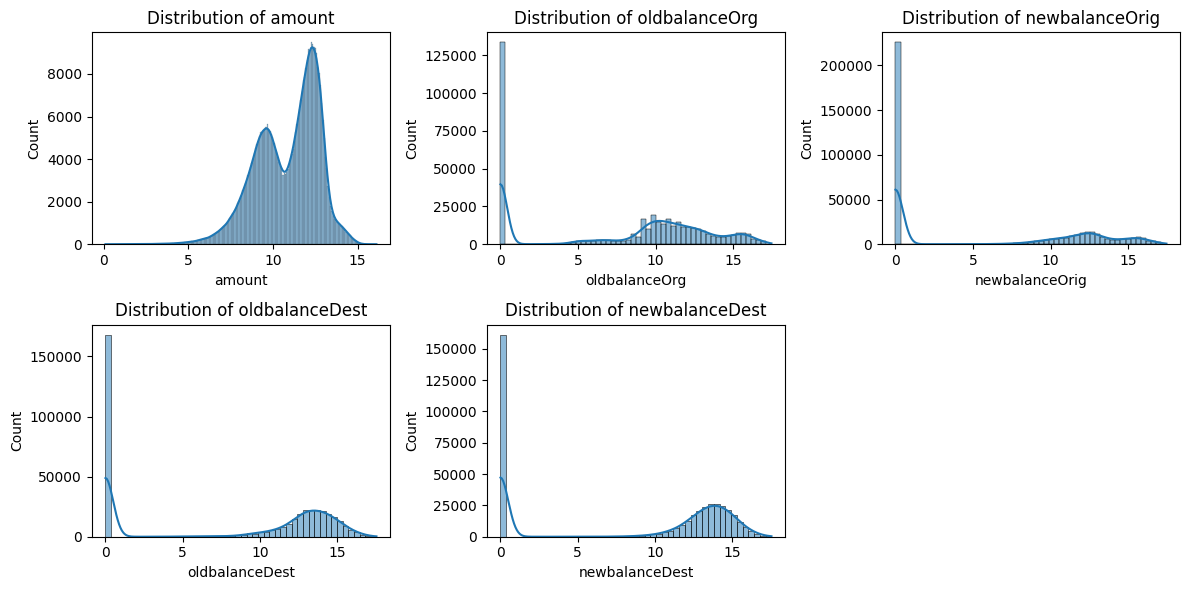

In [ ]:
continuous_feature = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
plt.figure(figsize=(12, 6))

for i, feature in enumerate(continuous_feature, 1):
    plt.subplot(2, 3, i)
    sns.histplot(np.log1p(df[feature]), kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()


**Zero balances are very frequent in this dataset. It may indicate a new or empty account, an account used only for a single transaction, or a failed transaction.**

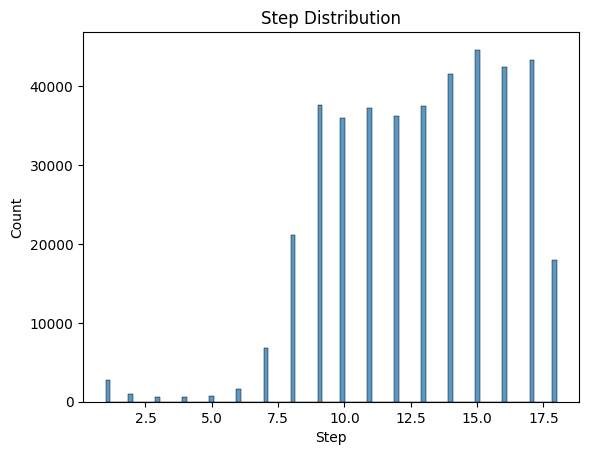

In [ ]:
sns.histplot(df['step'], bins=100)
plt.title('Step Distribution')
plt.xlabel('Step')
plt.ylabel('Count')
plt.show()

 No invalid values observed in this column since the step feature represents the hour of transaction within the simulation period, ranging from 1 to 743 hour

#Data Processing


The data processing workflow proceeds as follows:


**1 Drop Missing Values:**

Removed any records containing missing (NaN) values.

**2- Remove Duplicates:**

Identified and removed duplicate records to prevent data redundancy and bias.

**3- Filter Invalid Transactions -outliers-:**

Transactions with non-positive amounts and negative balance values were removed, as these are considered invalid entries in the context of financial transactions.

**4- Drop Unnecessary Features**

Removing The *nameOrig* and *nameDest* columns, which represent account identifiers as they do not provide meaningful numerical information for the model and could introduce noise or overfitting.

**5- Feature Engineering**

The feature destAlwaysZero is added to identify transactions where the destination account balance remains at zero both before and after the transaction, potentially indicating inactive, non-functional, or placeholder accounts often used in fraudulent scenarios

**6- Encode Categorical Feature**s

Convert transaction type categorical column into numerical form using one-hot encoding to prepare the data for neural network input.

**7- Scale Continuous Features**

Apply feature scaling to the continuous variables to normalize their ranges, which supports faster convergence and improved performance of the neural network.

Feature Engineering: Balance-Based Flags

In [ ]:
df.drop_duplicates(inplace=True)

df.dropna(inplace=True)

df = df[df['step'] > 0]
df = df[df['amount'] > 0]

df = df[(df['oldbalanceOrg'] >= 0) & (df['newbalanceOrig'] >= 0) &
        (df['oldbalanceDest'] >= 0) & (df['newbalanceDest'] >= 0)]

df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)



df.loc[:, 'destAlwaysZero'] = ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0)).astype(int)


df = pd.get_dummies(df, columns=['type'], prefix='type')

from sklearn.preprocessing import StandardScaler

continuous_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

scaler = StandardScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])



In [ ]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,destAlwaysZero,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-3.630143,-0.570159,-0.247415,-0.254157,-0.418346,-0.463398,0.0,0.0,1,False,False,False,True,False
1,-3.630143,-0.598153,-0.297653,-0.301115,-0.418346,-0.463398,0.0,0.0,1,False,False,False,True,False
2,-3.630143,-0.604061,-0.304762,-0.307575,-0.418346,-0.463398,1.0,0.0,1,False,False,False,False,True
3,-3.630143,-0.604061,-0.304762,-0.307575,-0.409342,-0.463398,1.0,0.0,0,False,True,False,False,False
4,-3.630143,-0.563741,-0.290801,-0.297615,-0.418346,-0.463398,0.0,0.0,1,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409482,1.582130,-0.129969,-0.281270,-0.239244,-0.323406,-0.428782,0.0,0.0,0,True,False,False,False,False
409483,1.582130,-0.233030,-0.235634,-0.203958,0.945339,0.755487,0.0,0.0,0,True,False,False,False,False
409484,1.582130,-0.267584,-0.199906,-0.171953,0.945663,0.759654,0.0,0.0,0,True,False,False,False,False
409485,1.582130,0.034021,-0.167499,-0.111313,-0.038200,-0.424317,0.0,0.0,0,True,False,False,False,False


In [ ]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409487 entries, 0 to 409486
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            409487 non-null  float64
 1   amount          409487 non-null  float64
 2   oldbalanceOrg   409487 non-null  float64
 3   newbalanceOrig  409487 non-null  float64
 4   oldbalanceDest  409487 non-null  float64
 5   newbalanceDest  409487 non-null  float64
 6   isFlaggedFraud  409487 non-null  float64
 7   destAlwaysZero  409487 non-null  int64  
 8   type_CASH_IN    409487 non-null  bool   
 9   type_CASH_OUT   409487 non-null  bool   
 10  type_DEBIT      409487 non-null  bool   
 11  type_PAYMENT    409487 non-null  bool   
 12  type_TRANSFER   409487 non-null  bool   
dtypes: bool(5), float64(7), int64(1)
memory usage: 30.1 MB


# model training

### we choice classification Neural Network algorithm

split the data into train-test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42, stratify=y)

### Build the Neutal Netwok model for binary classification

In [ ]:

model = Sequential ([
    Input(shape=(X_train.shape[1],)),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1,activation='sigmoid')
])



### compiling the model for training

In [ ]:
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy',
    tf.keras.metrics.AUC(name='auc')])

### Train the model

In [ ]:
class_weights = class_weight.compute_class_weight( 'balanced', classes=np.unique(y_train),y=y_train)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights= True)


history = model.fit(X_train, y_train,
          epochs= 50,
          batch_size= 128,
          validation_data=(X_test,y_test),
          callbacks =[early_stop],
          class_weight= dict(enumerate(class_weights)))

Epoch 1/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8095 - auc: 0.7990 - loss: 0.5627 - val_accuracy: 0.8384 - val_auc: 0.9638 - val_loss: 0.3058
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8380 - auc: 0.9265 - loss: 0.3500 - val_accuracy: 0.9164 - val_auc: 0.9640 - val_loss: 0.2275
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8972 - auc: 0.9369 - loss: 0.2533 - val_accuracy: 0.8537 - val_auc: 0.9664 - val_loss: 0.3303
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8804 - auc: 0.9410 - loss: 0.2605 - val_accuracy: 0.9037 - val_auc: 0.9633 - val_loss: 0.2806
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8861 - auc: 0.9180 - loss: 0.3222 - val_accuracy: 0.9609 - val_auc: 0.9547 - val_loss: 0.2315


# Visualizing Model Performane during Training

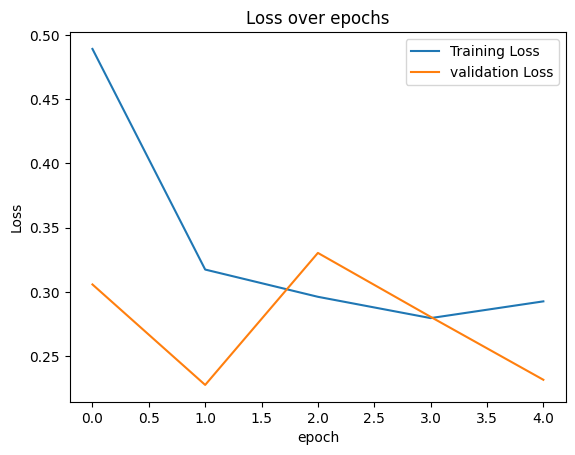

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()



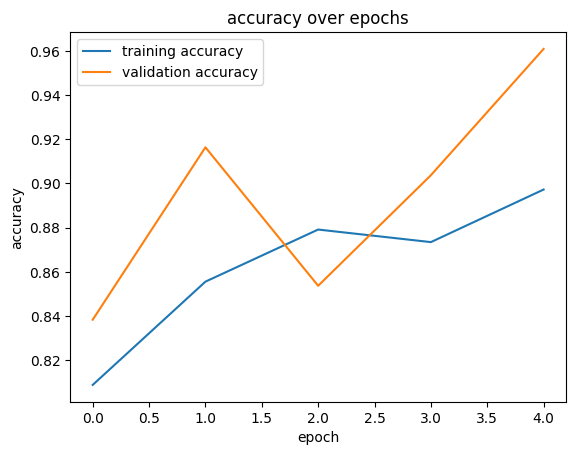

In [ ]:
 plt.plot(history.history['accuracy'],label='training accuracy')
 plt.plot(history.history['val_accuracy'],label='validation accuracy')
 plt.xlabel('epoch')
 plt.ylabel('accuracy')
 plt.title('accuracy over epochs')
 plt.legend()
 plt.show()

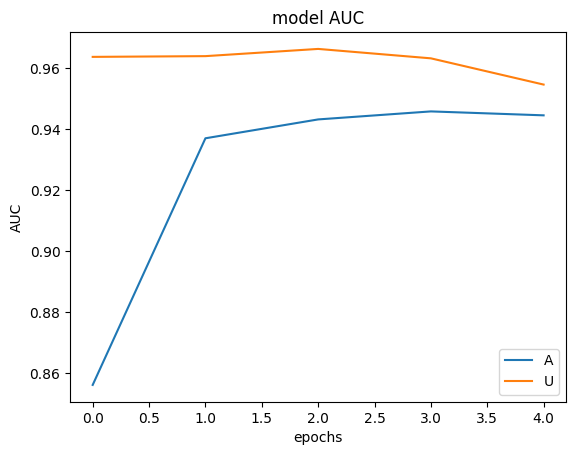

In [ ]:
plt.plot(history.history['auc'],label='Training AUC')
plt.plot(history.history['val_auc'],label=['Validation AUC'])
plt.title("model AUC")
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend('AUC')
plt.show()

# Model evaluation and testing









In [ ]:
#  Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

2560/2560 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


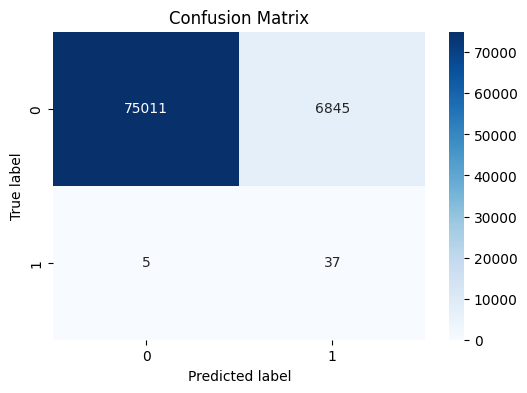

Confusion Matrix (Percentage):
[[91.6377541  8.3622459]
 [11.9047619 88.0952381]]


In [ ]:
cm = confusion_matrix(y_test, y_pred)

norm = colors.Normalize(vmin=0, vmax=cm.max())

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', norm=norm, cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("Confusion Matrix (Percentage):")
print(cm_percent)


In [ ]:

print('classification Report:\n')
print(classification_report(y_test,y_pred,target_names=['Not Fraudlunet','Fraudlunet']))



classification Report:

                precision    recall  f1-score   support

Not Fraudlunet       1.00      0.92      0.96     81856
    Fraudlunet       0.01      0.88      0.01        42

      accuracy                           0.92     81898
     macro avg       0.50      0.90      0.48     81898
  weighted avg       1.00      0.92      0.96     81898

